# TP 3 - Redes Neuronales
## Valentina Gonzalez - 59128


## Descarga del dataset

In [1]:
from PIL import Image
import numpy as np
import albumentations as A
from pathlib import Path

In [2]:
# instalar API de Kaggle y crear directorio y archivo para configurarla
!pip install --user kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json

api_token = {"username":"valentinagonzalez8","key":"51f509002e2c01d29317c519d6f26361"}

with open('/root/.kaggle/kaggle.json', 'w') as file:

 json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# descargar y descomprimir dataset
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks
!unzip pneumothorax-chest-xray-images-and-masks.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: siim-acr-pneumothorax/png_masks/5912_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5913_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5914_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5915_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5916_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5917_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5918_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5919_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/591_test_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/591_train_1_.png  
  inflating: siim-acr-pneumothorax/png_masks/5920_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5921_train_1_.png  
  inflating: siim-acr-pneumothorax/png_masks/5922_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5923_train_0_.png  
  inflating: siim-acr-pneumothor

In [5]:
# definir las transformaciones para aumentación de datos
'''

Transformaciones disponibles:
https://github.com/albumentations-team/albumentations#pixel-level-transforms

ejemplo de transformación compuesta:

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose()
])

'''
transform = False

## Generador de datos

In [6]:
import tensorflow as tf
import random
 
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(128,128), train=True, val = False,n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            files = [file.name for file in Path(path).glob("png_images/*train*1_.png")]
            self.filenames = files[0:(int(len(files)/100*90))]
            random.seed(4)
            random.shuffle(self.filenames)
        elif val:
            files = [file.name for file in Path(path).glob("png_images/*train*1_.png")]
            self.filenames = files[(int(len(files)/100*90)):]
            random.seed(4)
            np.random.shuffle(self.filenames)

        else:
            self.filenames = [file.name for file in Path(path).glob("png_images/*test*1_.png")]
            random.seed(4)
            np.random.shuffle(self.filenames)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

In [7]:
# tener cuidado con la selección del tamaño del batch. Al iniciar el entrenamiento
# dependiendo del tamaño de la red y el tamaño del batch, puede surgir un error OOM
# (out of memory) debido a las limitaciones de RAM de la GPU.
# En tal caso se deberá achicar el tamaño del batch
datagen = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = transform,
    batch_size = 64,
    train = True  
)


In [8]:
datagen_val = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,
    train = False,   
)

##  Función de costo que combina el coeficiente de Dice con la binary crossentropy 

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

In [10]:
# definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

## Entrenamiento de arquitectura de UNet

In [11]:
# definición de bloques para armar la arquitectura de UNet

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [12]:
# instanciación del modelo
model = UNet((128,128,1),start_ch=32,depth=5,batchnorm=False, residual = True,dropout=False)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [14]:
# compilación
model.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [15]:
model.fit(datagen, epochs = 10, validation_data=datagen_val)

Epoch 1/10
33/33 [==============================] - 88s 2s/step - loss: 0.6578 - binary_crossentropy: 0.3360 - dice_coef: 0.0204 - val_loss: 0.5181 - val_binary_crossentropy: 0.0823 - val_dice_coef: 0.0461
Epoch 2/10
33/33 [==============================] - 61s 2s/step - loss: 0.4971 - binary_crossentropy: 0.0761 - dice_coef: 0.0818 - val_loss: 0.4864 - val_binary_crossentropy: 0.0824 - val_dice_coef: 0.1097
Epoch 3/10
33/33 [==============================] - 62s 2s/step - loss: 0.4799 - binary_crossentropy: 0.0839 - dice_coef: 0.1241 - val_loss: 0.4681 - val_binary_crossentropy: 0.0812 - val_dice_coef: 0.1450
Epoch 4/10
33/33 [==============================] - 61s 2s/step - loss: 0.4580 - binary_crossentropy: 0.0854 - dice_coef: 0.1693 - val_loss: 0.4469 - val_binary_crossentropy: 0.0891 - val_dice_coef: 0.1953
Epoch 5/10
33/33 [==============================] - 61s 2s/step - loss: 0.4323 - binary_crossentropy: 0.0843 - dice_coef: 0.2197 - val_loss: 0.4279 - val_binary_crossentropy: 0

## Modelos

Armo funciones para poder probar y graficar distintos modelos 

In [16]:
import matplotlib.pyplot as plt

def datagen(batch, train, val, transform_ = False):
  datagen_val = DataGenerator(
      'siim-acr-pneumothorax/',
      "png_images/",
      "png_masks/",
      transform = transform_,
      batch_size = bs,
      train = train,
      val = val
      )
  return datagen_val

def Plot_loss(history): 
  plt.plot(history.history["loss"],label="Train")
  plt.plot(history.history["val_loss"],label="Val")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.plot(history.history["binary_crossentropy"],label="Train")
  plt.plot(history.history["val_binary_crossentropy"],label="Val")

  plt.title("Binary crossentropy")
  plt.legend()
  plt.show()

  plt.plot(history.history["dice_coef"],label="Train")
  plt.plot(history.history["val_dice_coef"],label="Val")

  plt.title("Coeficiente de Dice")
  plt.legend()
  plt.show()

def graficar_pred(data, pred):
  for idx in range(4):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(data[0][0][idx].reshape(128,128))
    ax1.set_title(f'Imagen {idx+1}')
    ax2.imshow(data[0][1][idx].reshape(128,128))
    ax2.set_title(f'Mask {idx+1}')
    ax3.imshow(pred[idx].reshape(128,128))
    ax3.set_title(f'Predicción {idx+1}')


In [17]:
def models (bs, batchnorm, depth, dropout, epochs, transform):
  
  datagen_train = datagen(batch = bs, train = True , val = False, transform_ = transform)
  datagen_val = datagen(batch = bs, train = False , val = True, transform_ = transform)
  datagen_test = datagen(batch = bs, train = False , val = False, transform_ = transform)

  # Instanciación del modelo
  model = UNet((128,128,1),start_ch=32,depth=depth,batchnorm=batchnorm, residual = True,dropout=dropout)
  
  # Compilación
  model.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

  history = model.fit(datagen_train, epochs = epochs, validation_data=datagen_val)

  preds_train = model.predict(datagen_train)
  preds_test = model.predict(datagen_test)

  Plot_loss(history)

  graficar_pred(datagen_train,preds_train)
  graficar_pred(datagen_test,preds_test)

  return(model.evaluate(datagen_test))


### Modelo 1 

Sin Data Augmentation, sin Transform y sin Batch Normalization



*   Batch Size = 32
*   Batch Normalization = False
*   Depth = 3
*   Epochs = 10
*   Transform = False




Epoch 1/10
66/66 [==============================] - 65s 897ms/step - loss: 0.5315 - binary_crossentropy: 0.1020 - dice_coef: 0.0391 - val_loss: 0.5024 - val_binary_crossentropy: 0.0897 - val_dice_coef: 0.0849
Epoch 2/10
66/66 [==============================] - 57s 856ms/step - loss: 0.4827 - binary_crossentropy: 0.0877 - dice_coef: 0.1223 - val_loss: 0.4488 - val_binary_crossentropy: 0.0788 - val_dice_coef: 0.1813
Epoch 3/10
66/66 [==============================] - 56s 848ms/step - loss: 0.4452 - binary_crossentropy: 0.0858 - dice_coef: 0.1953 - val_loss: 0.4441 - val_binary_crossentropy: 0.0868 - val_dice_coef: 0.1985
Epoch 4/10
66/66 [==============================] - 57s 859ms/step - loss: 0.4249 - binary_crossentropy: 0.0857 - dice_coef: 0.2359 - val_loss: 0.4329 - val_binary_crossentropy: 0.0828 - val_dice_coef: 0.2171
Epoch 5/10
66/66 [==============================] - 57s 859ms/step - loss: 0.4112 - binary_crossentropy: 0.0832 - dice_coef: 0.2608 - val_loss: 0.4062 - val_binary_

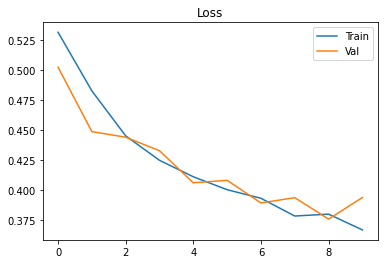

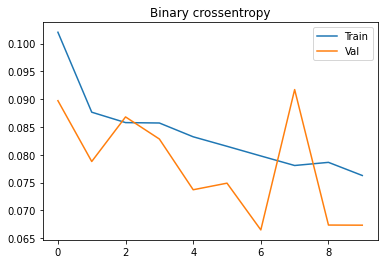

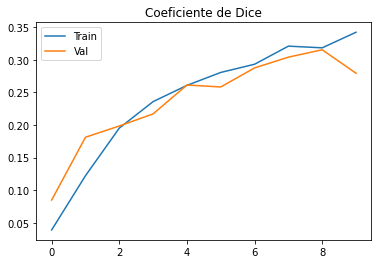

9/9 [==============================] - 6s 704ms/step - loss: 0.3781 - binary_crossentropy: 0.0692 - dice_coef: 0.3130
[0.37806522846221924, 0.06917686015367508, 0.3130463659763336]


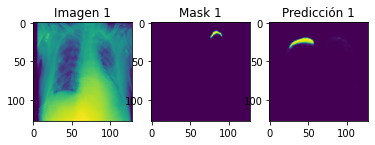

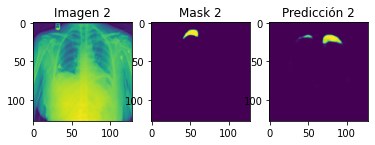

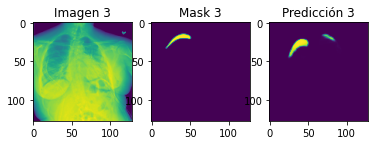

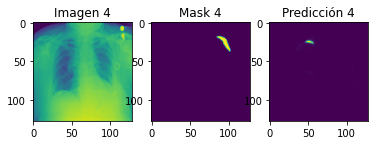

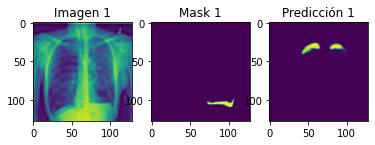

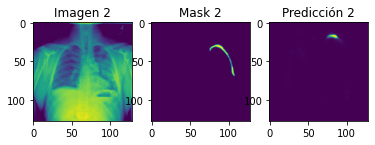

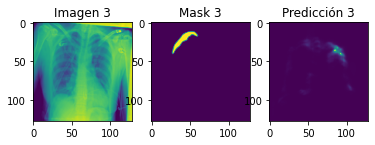

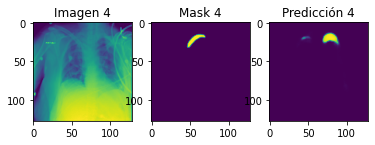

In [18]:
bs = 32
batchnorm = False
depth = 3
dropout = False
epochs = 10
transform = False

evaluate =models (bs, batchnorm, depth, dropout, epochs, transform)
print(evaluate)

Podemos observar a partir de los graficos de la Loss y Coeficiente de Dice que el modelo aún tiene capacidad de aumentar el overfitting. Esto se logra aumentando el numero de epochs. 

### Modelo 2 
Sin Data Augmentation ni Transform ni Batch Normalization

Aumento el número de epochs y el batch size 

*   Batch Size = 64
*   Batch Normalization = False
*   Depth = 3
*   Epochs = 20
*   Transform = False

Epoch 1/20
33/33 [==============================] - 61s 2s/step - loss: 0.5568 - binary_crossentropy: 0.1345 - dice_coef: 0.0209 - val_loss: 0.5162 - val_binary_crossentropy: 0.0683 - val_dice_coef: 0.0359
Epoch 2/20
33/33 [==============================] - 56s 2s/step - loss: 0.4983 - binary_crossentropy: 0.0767 - dice_coef: 0.0802 - val_loss: 0.4936 - val_binary_crossentropy: 0.0742 - val_dice_coef: 0.0869
Epoch 3/20
33/33 [==============================] - 57s 2s/step - loss: 0.4838 - binary_crossentropy: 0.0846 - dice_coef: 0.1170 - val_loss: 0.4629 - val_binary_crossentropy: 0.0757 - val_dice_coef: 0.1500
Epoch 4/20
33/33 [==============================] - 57s 2s/step - loss: 0.4627 - binary_crossentropy: 0.0866 - dice_coef: 0.1612 - val_loss: 0.4452 - val_binary_crossentropy: 0.0783 - val_dice_coef: 0.1880
Epoch 5/20
33/33 [==============================] - 56s 2s/step - loss: 0.4435 - binary_crossentropy: 0.0870 - dice_coef: 0.1999 - val_loss: 0.4492 - val_binary_crossentropy: 0

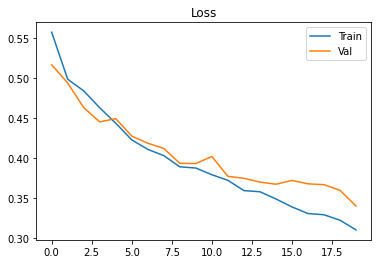

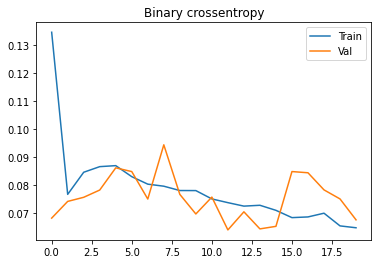

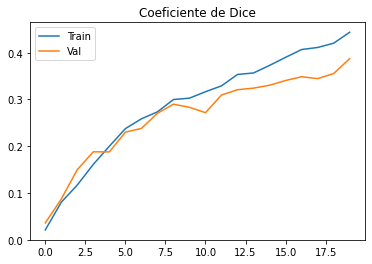

4/4 [==============================] - 6s 1s/step - loss: 0.3569 - binary_crossentropy: 0.0785 - dice_coef: 0.3647
[0.35686537623405457, 0.07846638560295105, 0.3647356629371643]


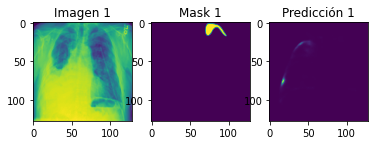

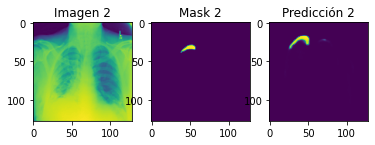

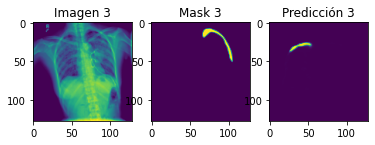

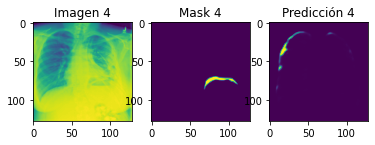

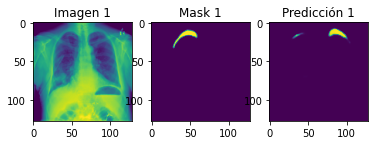

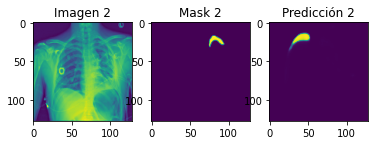

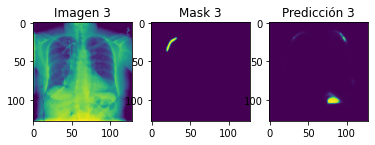

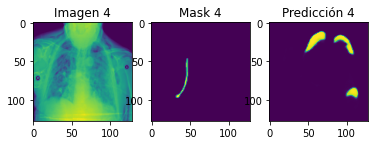

In [19]:
bs = 64
batchnorm = False
depth = 3
dropout = False
epochs = 20
transform = False

evaluate = models (bs, batchnorm, depth, dropout, epochs, transform)
print(evaluate)

Se puede observar mediante los graficos que aún se puede seguir aumentando el overfitting del modelo. Sin embargo, aumentar más el numero de epochs llevaría mas de 30 minutos en compilar (no recomendado). Con lo cual, se intentarán otros métodos para mejorar los resultados obtenidos. 

Por otro lado, se observa una leve mejora en el resultado obtenido del coeficiente de Dice.

### Modelo 3

Sin Data Augmentation ni Transform ni  Batch Normalization

Aumentamos únicamente el batch size

*   Batch Size = 128
*   Batch Normalization = True
*   Depth = 3
*   Epochs = 20
*   Transform = False

Epoch 1/20
16/16 [==============================] - 72s 3s/step - loss: 0.5863 - binary_crossentropy: 0.1859 - dice_coef: 0.0133 - val_loss: 0.5285 - val_binary_crossentropy: 0.0697 - val_dice_coef: 0.0128
Epoch 2/20
16/16 [==============================] - 55s 3s/step - loss: 0.5225 - binary_crossentropy: 0.0727 - dice_coef: 0.0278 - val_loss: 0.5199 - val_binary_crossentropy: 0.0794 - val_dice_coef: 0.0396
Epoch 3/20
16/16 [==============================] - 55s 3s/step - loss: 0.5095 - binary_crossentropy: 0.0737 - dice_coef: 0.0548 - val_loss: 0.5003 - val_binary_crossentropy: 0.0746 - val_dice_coef: 0.0741
Epoch 4/20
16/16 [==============================] - 55s 3s/step - loss: 0.4928 - binary_crossentropy: 0.0812 - dice_coef: 0.0957 - val_loss: 0.4952 - val_binary_crossentropy: 0.0791 - val_dice_coef: 0.0887
Epoch 5/20
16/16 [==============================] - 54s 3s/step - loss: 0.4813 - binary_crossentropy: 0.0791 - dice_coef: 0.1165 - val_loss: 0.4570 - val_binary_crossentropy: 0

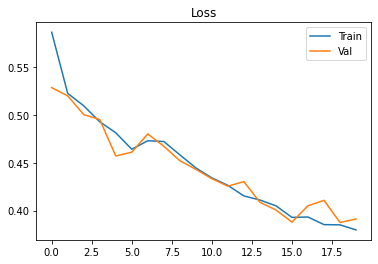

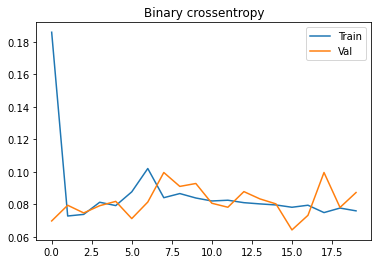

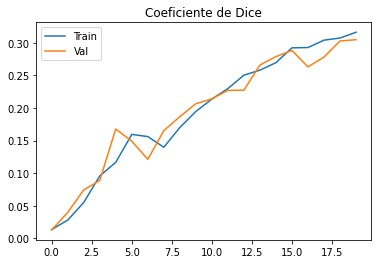

2/2 [==============================] - 6s 3s/step - loss: 0.3849 - binary_crossentropy: 0.0854 - dice_coef: 0.3156
[0.3849170207977295, 0.08541218191385269, 0.3155781924724579]


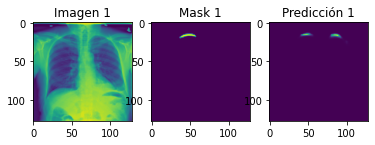

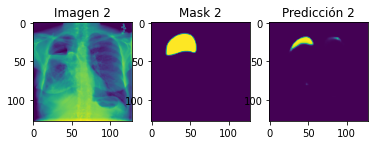

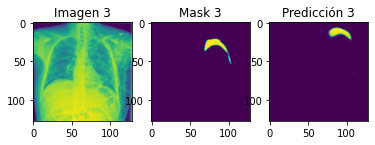

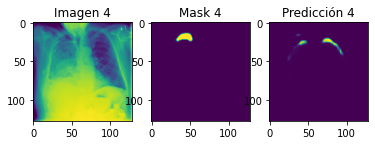

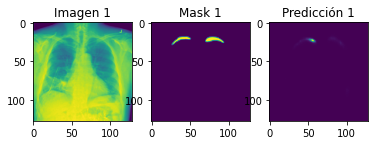

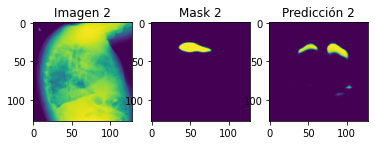

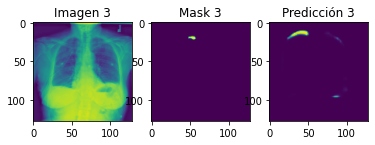

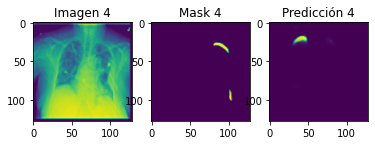

In [20]:
bs = 128
batchnorm = False
depth = 3
dropout = False
epochs = 20
transform = False

evaluate = models (bs, batchnorm, depth, dropout, epochs, transform)
print(evaluate)

No notamos una mejora evidente de los resultados obtenidos. De hecho, se obtiene un coeficiente de Dice menor al obtenido con un batch size de 64 (parecido al obtenido con un batch size de 32).

### Modelo 4 

Sin Data Augmentation ni Transform

Utilizo Batch Normalization

*   Batch Size = 64
*   Batch Normalization = True
*   Depth = 3
*   Epochs = 20
*   Transform = False

Epoch 1/20
33/33 [==============================] - 65s 2s/step - loss: 0.4745 - binary_crossentropy: 0.1198 - dice_coef: 0.1708 - val_loss: 0.5393 - val_binary_crossentropy: 0.0927 - val_dice_coef: 0.0141
Epoch 2/20
33/33 [==============================] - 57s 2s/step - loss: 0.3897 - binary_crossentropy: 0.0788 - dice_coef: 0.2994 - val_loss: 0.5434 - val_binary_crossentropy: 0.0892 - val_dice_coef: 0.0024
Epoch 3/20
33/33 [==============================] - 57s 2s/step - loss: 0.3709 - binary_crossentropy: 0.0758 - dice_coef: 0.3339 - val_loss: 0.5560 - val_binary_crossentropy: 0.1128 - val_dice_coef: 6.6697e-04
Epoch 4/20
33/33 [==============================] - 56s 2s/step - loss: 0.3564 - binary_crossentropy: 0.0740 - dice_coef: 0.3611 - val_loss: 0.5583 - val_binary_crossentropy: 0.1169 - val_dice_coef: 3.9195e-04
Epoch 5/20
33/33 [==============================] - 57s 2s/step - loss: 0.3486 - binary_crossentropy: 0.0732 - dice_coef: 0.3759 - val_loss: 0.5476 - val_binary_crossen

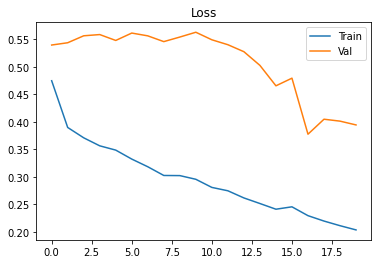

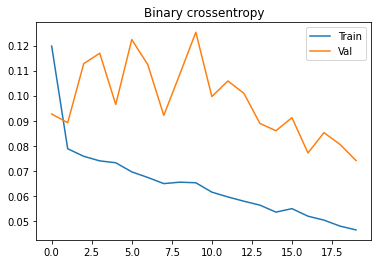

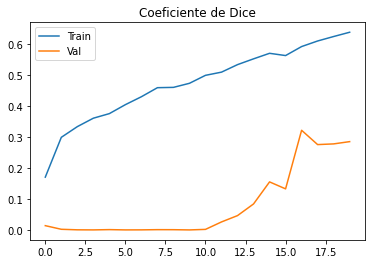

4/4 [==============================] - 6s 1s/step - loss: 0.4226 - binary_crossentropy: 0.0851 - dice_coef: 0.2398
[0.42264944314956665, 0.08507367223501205, 0.23977482318878174]


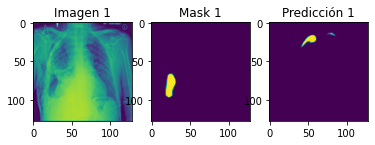

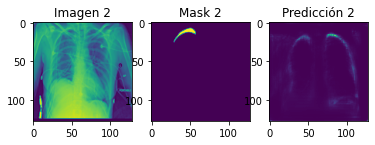

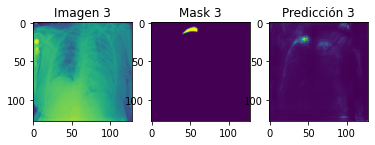

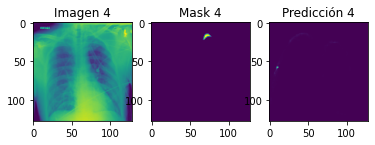

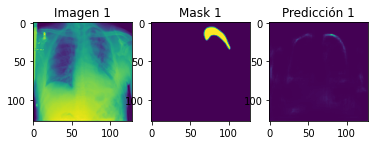

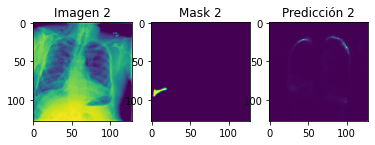

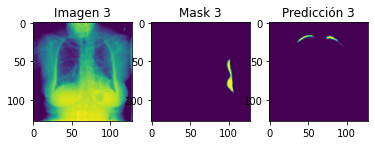

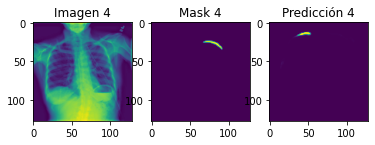

In [24]:
bs = 64
batchnorm = True
depth = 3
dropout = False
epochs = 20
transform = False


evaluate =models (bs, batchnorm, depth, dropout, epochs, transform)
print(evaluate)

Se puede observar que los resultados obtenidos son los peores hasta ahora. Es decir, un coeficiente de Dice menor a cualquiera de los modelos probados (todos sin Batch Normalization). Con lo cual, continuaremos realizando modelos que sin Batch Normalization.

### Modelo 5 

Sin Data Augmentation ni Batch Normalization 

Utilizo Transform

*   Batch Size = 128
*   Batch Normalization = False
*   Depth = 3
*   Epochs = 20

Epoch 1/20
16/16 [==============================] - 66s 4s/step - loss: 0.5895 - binary_crossentropy: 0.1920 - dice_coef: 0.0130 - val_loss: 0.5278 - val_binary_crossentropy: 0.0705 - val_dice_coef: 0.0148
Epoch 2/20
16/16 [==============================] - 62s 4s/step - loss: 0.5249 - binary_crossentropy: 0.0757 - dice_coef: 0.0259 - val_loss: 0.5171 - val_binary_crossentropy: 0.0654 - val_dice_coef: 0.0313
Epoch 3/20
16/16 [==============================] - 61s 4s/step - loss: 0.5167 - binary_crossentropy: 0.0716 - dice_coef: 0.0382 - val_loss: 0.5148 - val_binary_crossentropy: 0.0682 - val_dice_coef: 0.0385
Epoch 4/20
16/16 [==============================] - 61s 4s/step - loss: 0.5039 - binary_crossentropy: 0.0767 - dice_coef: 0.0690 - val_loss: 0.5085 - val_binary_crossentropy: 0.0871 - val_dice_coef: 0.0701
Epoch 5/20
16/16 [==============================] - 70s 4s/step - loss: 0.4972 - binary_crossentropy: 0.0850 - dice_coef: 0.0906 - val_loss: 0.4927 - val_binary_crossentropy: 0

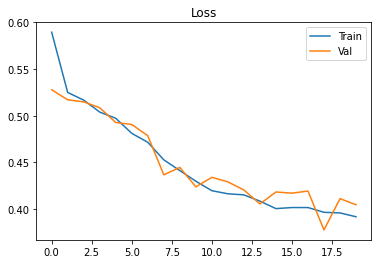

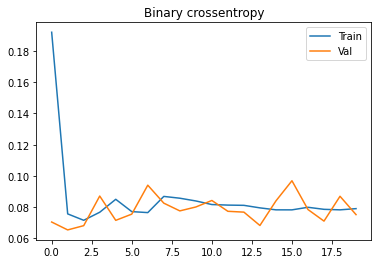

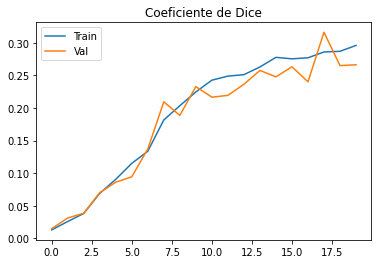

2/2 [==============================] - 7s 3s/step - loss: 0.3949 - binary_crossentropy: 0.0816 - dice_coef: 0.2918
[0.3949078321456909, 0.08164869248867035, 0.2918330430984497]


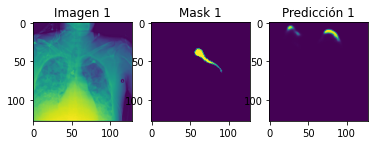

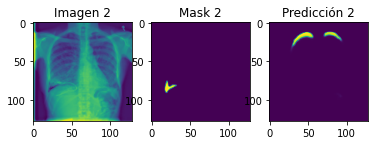

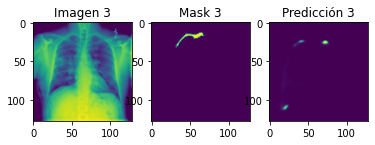

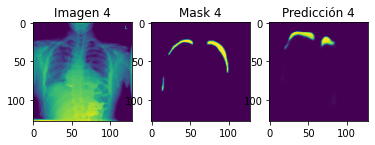

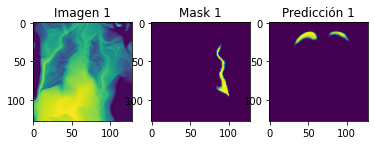

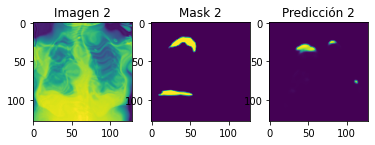

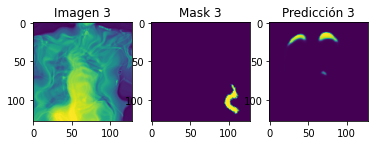

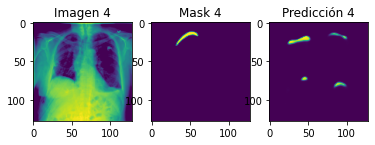

In [25]:
bs = 128
batchnorm = False
depth = 3
dropout = False
epochs = 20
transform = transform = A.Compose([
    A. ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.RandomBrightnessContrast()
])


evaluate = models (bs, batchnorm, depth, dropout, epochs, transform)
print(evaluate)

En este caso, al igual que el anterior, se puede observar que los resultados obtenidos son los peores hasta ahora. Es decir, se obtiene un coeficiente de Dice menor a cualquiera de los modelos probados (sin Transform). 

## Conclusión

Se probaron distintos modelos, tanto con distintos parámetros de Batch Size y epochs así como modelos con y sin Batch Normalization y Transformaciones de data augmentation. 

Se descubrió que tanto las transformaciones como el Batch Normalization no generaron una mejora en los resultados (coeficiente de Dice) sino que todo lo contrario. 

Además, se descubrió que aumentando el numero de epochs se lograron mejores resultados (mayor overfitting y mayor coeficiente de Dice). Sin embargo, no se pudo probar un numero de batch mayor a 20 debido a el tiempo de ejecución que toma.

Finalmente, el mejor resultado se obtuvo eligiendo un batch size de 64 y un numero de epochs de 20, sin transformaciones ni batch normalization. En este caso, se obtuvo un coeficiente de Dice del conjunto de testeo de 0.36 aproximadamente.

En este último caso, como puede verse en el gráfico del Coeficiente de Dice y el de la Loss, pareciera que aún habia mas espacio para el overfitteo del sistema con estos parametros. Con lo cual, aumentando el número de epochs podría conseguirse un mayor coeficiente de Dice, y por ende un mayor overfitting. Luego, deberían probarse distintos métodos de regularización (como dropout o L2) para intentar reducir el overfitting.